In [1]:
# This is a tutorial to create a simple prediction model to perform the following
# 1. Read in and show basic information about the training data
# 2. Create a simple prediction model on a portion of the training data
# 3. Test the quality of the model on a later portion of the data
# 4. Create a final model using all the training data based on the best choices above
# 5. Apply that model to the test data, to be scored on the kaggle.com site

# FILES NEEDED: for this code to work, you will need train_luc.csv and test_luc.csv
# in the same folder as this notebook

## Team Members:  Farhan Almufleh, Keith Santamaria, Sri Tammineni, Jana Voege
We started by producing visualizations (primarily histograms) of rider counts (total, registered, and casual) by hour, using various subsets of the data, such as each season and each weather condition.
We utilized the following resources to learn how to concatenate and properly sort:  https://pythonexamples.org/pandas-concatenate-dataframes/ and https://datatofish.com/sort-pandas-dataframe/
We created new features, including dayofweek, hour, month, and year.  These prove to help our models.
We fit models using Decision Tree, Random Forest, and k Nearest Neighbors (kNN) Regressor.  The best performance came from combining separate models for casual and registered users using Randomforest Regressor with 100 estimators.

In [2]:
import pandas as pd
import numpy as np
import csv as csv
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# read the data and display the first 5 rows
train_df = pd.read_csv('train_luc.csv', header=0)

print("\nNumber of samples:",train_df.shape[0],"and number of features:",train_df.shape[1],"\n")

train_df.head()


Number of samples: 9174 and number of features: 12 



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# Understanding basic stats of the data set

In [4]:
# read about the data elsewhere, however, it is critical to observe the data to make sure
# everything is read in correctly and matches the description

train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000
mean,2.505559,0.031284,0.678875,1.414868,20.130401,23.578433,61.715064,12.737931,35.713647,154.868106,190.581753
std,1.116618,0.174094,0.466934,0.635363,7.940504,8.617957,19.401829,8.199027,49.667738,150.981155,181.011530
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,4.000000,35.000000,41.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,61.000000,11.001400,16.000000,117.000000,144.000000
75%,4.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,48.000000,222.000000,282.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,362.000000,886.000000,977.000000


# Create a new feature

In [5]:
# let's take datetime (which isn't very useful to algorithms) and turn it into something useful.
# e.g. this will create a new column for the hour
def hour_of_day(dt):
    return datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").time().hour
def month_of_day(dt):
    return datetime.strptime(dt,"%Y-%m-%d %H:%M:%S").date().month
def year_of_day(dt): 
    return datetime.strptime(dt,"%Y-%m-%d %H:%M:%S").date().year
train_df['year'] = train_df['datetime'].map(year_of_day)
train_df['month'] = train_df['datetime'].map(month_of_day)
train_df['hour'] = train_df['datetime'].map(hour_of_day)
train_df['dayofweek'] = pd.DatetimeIndex(train_df['datetime']).dayofweek
train_df.head()
# note the new column on the right labelled "hour"

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


# Make visualizations to better understand your data

In [6]:
season = np.unique(train_df['season'])
print("seasons", season)

spring_df = train_df[ (train_df['season'] == 1)]
summer_df = train_df[ (train_df['season'] == 2)]
fall_df = train_df[ (train_df['season'] == 3 )]
winter_df = train_df[ (train_df['season'] == 4)]

seasons [1 2 3 4]


hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
0 26.0625
1 16.916666666666668
2 12.188888888888888
3 7.666666666666667
4 3.3411764705882354
5 10.24731182795699
6 42.854166666666664
7 125.625
8 256.1770833333333
9 152.0625
10 94.41666666666667
11 113.28125
12 144.39583333333334
13 149.9375
14 138.76041666666666
15 145.70833333333334
16 176.95833333333334
17 272.71875
18 248.57291666666666
19 168.51041666666666
20 120.08333333333333
21 92.09375
22 69.85416666666667
23 43.21875


Text(0.5, 1.0, 'Measured bike use over 2 springs')

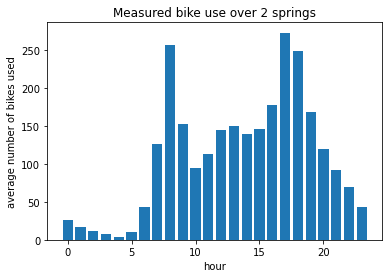

In [7]:
hours = np.unique(train_df['hour'])
print("hours:",hours)

hours_mean = {}
for h in hours:
    temp_df = spring_df.loc[spring_df['hour'] == h]
    hours_mean[h] = temp_df['count'].mean()
    print(h,hours_mean[h])

# plot the results. Maybe should see peaks from bike commuting or evening use
plt.bar(hours,[hours_mean[h] for h in hours])
plt.xlabel("hour")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 springs")

hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
0 58.78125
1 35.895833333333336
2 23.21875
3 11.680851063829786
4 6.242105263157895
5 20.1875
6 82.42708333333333
7 229.20833333333334
8 386.1354166666667
9 238.625
10 191.72916666666666
11 237.4375
12 286.34375
13 291.34375
14 271.875
15 284.40625
16 356.65625
17 530.2395833333334
18 490.5208333333333
19 367.3333333333333
20 263.3229166666667
21 197.63541666666666
22 151.08333333333334
23 100.51041666666667


Text(0.5, 1.0, 'Measured bike use over 2 summers')

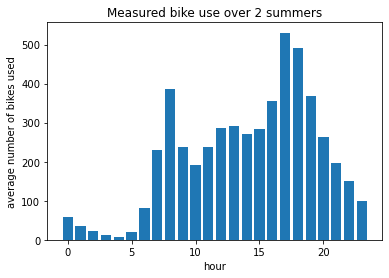

In [8]:
hours = np.unique(train_df['hour'])
print("hours:",hours)

hours_mean = {}
for h in hours:
    temp_df = summer_df.loc[summer_df['hour'] == h]
    hours_mean[h] = temp_df['count'].mean()
    print(h,hours_mean[h])

# plot the results. Maybe should see peaks from bike commuting or evening use
plt.bar(hours,[hours_mean[h] for h in hours])
plt.xlabel("hour")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 summers")

hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
0 55.307291666666664
1 34.005221932114885
2 22.785145888594165
3 11.843835616438357
4 6.349462365591398
5 19.62204724409449
6 75.59375
7 211.3359375
8 360.078125
9 220.3203125
10 173.75
11 209.1328125
12 256.2265625
13 257.546875
14 242.84635416666666
15 252.71354166666666
16 315.1171875
17 465.546875
18 427.2526041666667
19 314.0364583333333
20 227.37760416666666
21 172.49479166666666
22 133.27864583333334
23 89.99739583333333


Text(0.5, 1.0, 'Measured bike use over 2 years')

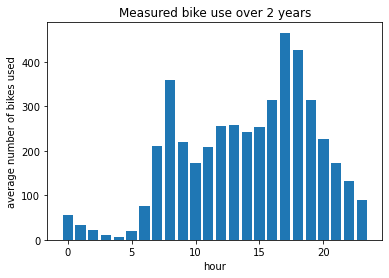

In [9]:
# now let's take a look at the amerage amount of bike use for each hour of the day
# as a "sanity check" to make sure the data makes sense before going further
hours = np.unique(train_df['hour'])
print("hours:",hours)

hours_mean = {}
for h in hours:
    temp_df = train_df.loc[train_df['hour'] == h]
    hours_mean[h] = temp_df['count'].mean()
    print(h,hours_mean[h])

# plot the results. Maybe should see peaks from bike commuting or evening use
plt.bar(hours,[hours_mean[h] for h in hours])
plt.xlabel("hour")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 years")

hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
0 45.0390625
1 27.558746736292427
2 18.013262599469495
3 9.186301369863013
4 5.099462365591398
5 18.15223097112861
6 71.48177083333333
7 200.7421875
8 338.8776041666667
9 189.84114583333334
10 127.9296875
11 149.20052083333334
12 187.82552083333334
13 183.94010416666666
14 166.8203125
15 177.78125
16 241.10677083333334
17 391.2291666666667
18 366.5963541666667
19 265.0963541666667
20 190.60677083333334
21 143.69270833333334
22 110.734375
23 74.5


Text(0.5, 1.0, 'Measured bike use over 2 years')

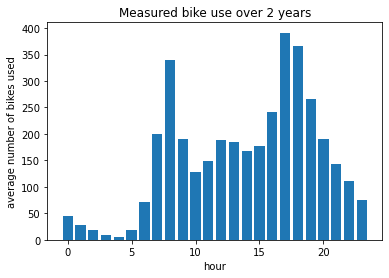

In [10]:
hours = np.unique(train_df['hour'])
print("hours:",hours)

hours_mean = {}
for h in hours:
    temp_df = train_df.loc[train_df['hour'] == h]
    hours_mean[h] = temp_df['registered'].mean()
    print(h,hours_mean[h])

# plot the results. Maybe should see peaks from bike commuting or evening use
plt.bar(hours,[hours_mean[h] for h in hours])
plt.xlabel("hour")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 years")

hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
0 10.268229166666666
1 6.446475195822455
2 4.771883289124668
3 2.6575342465753424
4 1.25
5 1.4698162729658792
6 4.111979166666667
7 10.59375
8 21.200520833333332
9 30.479166666666668
10 45.8203125
11 59.932291666666664
12 68.40104166666667
13 73.60677083333333
14 76.02604166666667
15 74.93229166666667
16 74.01041666666667
17 74.31770833333333
18 60.65625
19 48.940104166666664
20 36.770833333333336
21 28.802083333333332
22 22.544270833333332
23 15.497395833333334


Text(0.5, 1.0, 'Measured bike use over 2 years')

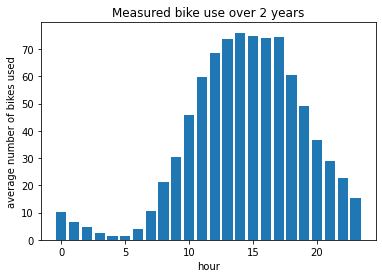

In [11]:
hours = np.unique(train_df['hour'])
print("hours:",hours)

hours_mean = {}
for h in hours:
    temp_df = train_df.loc[train_df['hour'] == h]
    hours_mean[h] = temp_df['casual'].mean()
    print(h,hours_mean[h])

# plot the results. Maybe should see peaks from bike commuting or evening use
plt.bar(hours,[hours_mean[h] for h in hours])
plt.xlabel("hour")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 years")

temp: [ 0.82  1.64  2.46  3.28  4.1   4.92  5.74  6.56  7.38  8.2   9.02  9.84
 10.66 11.48 12.3  13.12 13.94 14.76 15.58 16.4  17.22 18.04 18.86 19.68
 20.5  21.32 22.14 22.96 23.78 24.6  25.42 26.24 27.06 27.88 28.7  29.52
 30.34 31.16 31.98 32.8  33.62 34.44 35.26 36.08 36.9  37.72 38.54 39.36
 41.  ] 49


Text(0.5, 1.0, 'Measured bike use over 2 years')

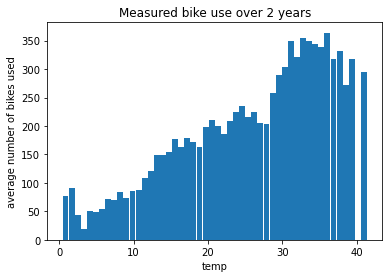

In [12]:
temp = np.unique(train_df['temp'])
print("temp:", temp, temp.size)

temp_mean = {}
for t in temp:
  temp_df = train_df.loc[train_df['temp'] == t]
  temp_mean[t] = temp_df['count'].mean()

plt.bar(temp,[temp_mean[t] for t in temp])
plt.xlabel("temp")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 years")

temp: [ 0.82  1.64  2.46  3.28  4.1   4.92  5.74  6.56  7.38  8.2   9.02  9.84
 10.66 11.48 12.3  13.12 13.94 14.76 15.58 16.4  17.22 18.04 18.86 19.68
 20.5  21.32 22.14 22.96 23.78 24.6  25.42 26.24 27.06 27.88 28.7  29.52
 30.34 31.16 31.98 32.8  33.62 34.44 35.26 36.08 36.9  37.72 38.54 39.36
 41.  ] 49


Text(0.5, 1.0, 'Measured bike use over 2 years')

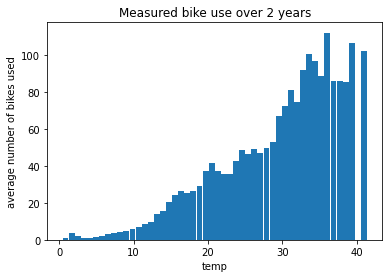

In [13]:
temp = np.unique(train_df['temp'])
print("temp:", temp, temp.size)

temp_mean = {}
for t in temp:
  temp_df = train_df.loc[train_df['temp'] == t]
  temp_mean[t] = temp_df['casual'].mean()

plt.bar(temp,[temp_mean[t] for t in temp])
plt.xlabel("temp")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 years")

temp: [ 0.82  1.64  2.46  3.28  4.1   4.92  5.74  6.56  7.38  8.2   9.02  9.84
 10.66 11.48 12.3  13.12 13.94 14.76 15.58 16.4  17.22 18.04 18.86 19.68
 20.5  21.32 22.14 22.96 23.78 24.6  25.42 26.24 27.06 27.88 28.7  29.52
 30.34 31.16 31.98 32.8  33.62 34.44 35.26 36.08 36.9  37.72 38.54 39.36
 41.  ] 49


Text(0.5, 1.0, 'Measured bike use over 2 years')

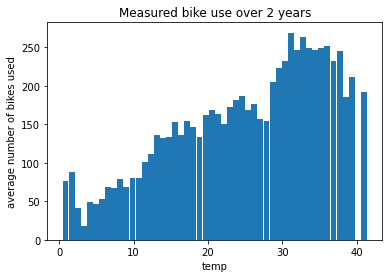

In [14]:
temp = np.unique(train_df['temp'])
print("temp:", temp, temp.size)

temp_mean = {}
for t in temp:
  temp_df = train_df.loc[train_df['temp'] == t]
  temp_mean[t] = temp_df['registered'].mean()

plt.bar(temp,[temp_mean[t] for t in temp])
plt.xlabel("temp")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 years")

windspeed: [ 0.      6.0032  7.0015  8.9981 11.0014 12.998  15.0013 16.9979 19.0012
 19.9995 22.0028 23.9994 26.0027 27.9993 30.0026 31.0009 32.9975 35.0008
 36.9974 39.0007 40.9973 43.0006 43.9989 46.0022 47.9988 51.9987 56.9969] 27


Text(0.5, 1.0, 'Measured bike use over 2 years')

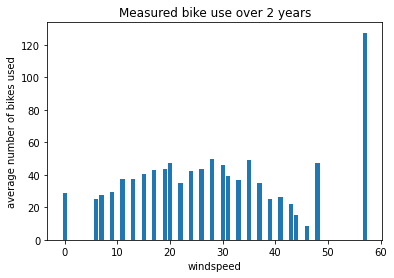

In [15]:
windspeed = np.unique(train_df['windspeed'])
print("windspeed:", windspeed, windspeed.size)

windspeed_mean = {}
for w in windspeed:
  temp_df = train_df.loc[train_df['windspeed'] == w]
  windspeed_mean[w] = temp_df['casual'].mean()

plt.bar(windspeed,[windspeed_mean[w] for w in windspeed])
plt.xlabel("windspeed")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 years")

humidity: [  0  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31
  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  97 100] 83


Text(0.5, 1.0, 'Measured bike use over 2 years')

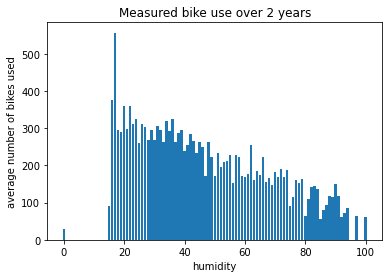

In [16]:
humidity = np.unique(train_df['humidity'])
print("humidity:", humidity, humidity.size)

humidity_mean = {}
for h in humidity:
  temp_df = train_df.loc[train_df['humidity'] == h ]
  humidity_mean[h] = temp_df['count'].mean()

plt.bar(humidity,[humidity_mean[h] for h in humidity])
plt.xlabel("humidity")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 years")

# Pick the features and the model

In [17]:
# pick your features
cols = ['hour', 'month', 'workingday', 'year', 'weather', 'season', 'temp', 'atemp', 'humidity', 'windspeed','season','dayofweek'] 
# cols = ['hour', 'month', 'workingday', 'year', 'weather'] # RMS error: ~ 60 #DT broke under 59 for 1 run
# cols = ['hour', 'month', 'workingday', 'year'] # RMS error: ~ 60 #DT
# cols = ['hour', 'month', 'workingday', 'season'] # RMS error: ~ 87 #DT
# cols = ['hour','month', 'workingday'] # RMS error: ~ 88.50522707578871 #DT
# cols = ['hour','month'] # RMS error : ~ 115.20136523892982 #DT
# try more features later, like...
# cols = ['hour','season']

# pick your model (you should consider adjusting optional parameters too)
# reading in a few models we can pick from (there are many others)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# pick one by commenting/uncommenting
#model = DecisionTreeRegressor()
#model = LinearRegression()
#model = KNeighborsRegressor(n_neighbors = 5)
#model = LinearSVR()
model = RandomForestRegressor(n_estimators = 100)
model2 = RandomForestRegressor(n_estimators = 100)

#print("columns selected for later:",cols)
print(model) # to get an idea of parameters and confirm model chosen

RandomForestRegressor()


# Separate your training and test sets

In [18]:
y = train_df['count']

# this is a way of splitting training and testing by hand
# however, there are tools to do this automatically
# google "cross validation" for a better/more advanced strategy
#--------------------

n = len(train_df) # get number of rows in the training set
training_size = 0.75 # fraction of training data to split off for internal testing

# set up separate training and testing sets
# in this case using shuffled array indices
# there are many more ways to do this too
indices = np.array(range(n)) # makes an array of row indices in order
from numpy.random import shuffle
shuffle(indices)
split_point = int(n*training_size)
mytrain_i = indices[0:split_point]
mytest_i = indices[split_point:]

# now use those shuffled indices to separating training from test dataframes
new_train_df = train_df.iloc[mytrain_i]
new_test_df = train_df.iloc[mytest_i]
y_train = y[mytrain_i]
y_test = y[mytest_i]

print("samples in the new training subset:",len(new_train_df))
print("samples in the new test subset:",len(new_test_df))

samples in the new training subset: 6880
samples in the new test subset: 2294


## Separating training and validation sets based off season

In [19]:
spring_train_df = new_train_df[ (new_train_df['season'] == 1)]
summer_train_df = new_train_df[ (new_train_df['season'] == 2)]
fall_train_df = new_train_df[ (new_train_df['season'] == 3 )]
winter_train_df = new_train_df[ (new_train_df['season'] == 4)]

spring_validation_df = new_test_df[ (new_test_df['season'] == 1)]
summer_validation_df = new_test_df[ (new_test_df['season'] == 2)]
fall_validation_df = new_test_df[ (new_test_df['season'] == 3 )]
winter_validation_df = new_test_df[ (new_test_df['season'] == 4)]

non_spring_train_df = new_train_df[ (new_train_df['season'] != 1)]
non_spring_validation_df = new_test_df[ (new_test_df['season'] != 1)]

## Separating training and validation sets based off working day

In [20]:
is_working_train_df = new_train_df[ (new_train_df['workingday'] == 1)]
non_working_train_df = new_train_df[ (new_train_df['workingday'] == 0)]

is_working_validation_df = new_test_df[ (new_test_df['workingday'] == 1)]
non_working_validation_df = new_test_df[ (new_test_df['workingday'] == 0)]

# Fit the model to a portion of the training set, test on the rest and evaluate

In [21]:
# fit the model to the training subset of original training data
model.fit(new_train_df[cols], new_train_df['count'])

# predict on the testing subset of the original training data
pred_count = model.predict(new_test_df[cols])


# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(new_test_df['count'],pred_count))
print("RMS error:",rms)

RMS error: 38.69904608210688


## Testing workingday vs nonworking day models

In [22]:
model.fit(is_working_train_df[cols], is_working_train_df['count'])
is_working_pred_count = model.predict(is_working_validation_df[cols])

model.fit(non_working_train_df[cols], non_working_train_df['count'])
non_working_pred_count = model.predict(non_working_validation_df[cols])

rms = np.sqrt(mean_squared_error(is_working_validation_df['count'],is_working_pred_count ))
print("RMS error:",rms)

rms = np.sqrt(mean_squared_error(non_working_validation_df['count'],non_working_pred_count ))
print("RMS error:",rms)

working_non_working_combined_pred_count = np.concatenate( (is_working_pred_count ,non_working_pred_count))

working_non_working_df = [is_working_validation_df, non_working_validation_df]
working_non_working_df = pd.concat(working_non_working_df, sort = False)

rms = np.sqrt(mean_squared_error(working_non_working_df['count'],working_non_working_combined_pred_count ))
print("RMS error:",rms)

RMS error: 38.8513777237845
RMS error: 42.77678166118258
RMS error: 40.21692896019722


## Testing casual vs registered

In [23]:
#Fit and predict for casual users
model.fit(new_train_df[cols], new_train_df['casual'])
pred_test_casual = model.predict(new_test_df[cols])
pred_train_casual = model.predict(new_train_df[cols])

#Fit and predict for registered users
model2.fit(new_train_df[cols], new_train_df['registered'])
pred_test_registered = model2.predict(new_test_df[cols])
pred_train_registered = model2.predict(new_train_df[cols])

pred_test = pred_test_casual + pred_test_registered
pred_train = pred_train_casual + pred_train_registered

# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(y_test,pred_test))
print("RMS error - testing data:",rms)
rm2 = np.sqrt(mean_squared_error(y_train,pred_train))
print("RMS error - training data:",rm2)

RMS error - testing data: 37.816349833777956
RMS error - training data: 14.93327386571854


## Testing our seasonal models

In [24]:
#cols = ['hour']
model.fit(spring_train_df[cols], spring_train_df['count'])
spring_pred_count = model.predict(spring_validation_df[cols])

model.fit(summer_train_df[cols], summer_train_df['count'])
summer_pred_count = model.predict(summer_validation_df[cols])

model.fit(fall_train_df[cols], fall_train_df['count'])
fall_pred_count = model.predict(fall_validation_df[cols])

model.fit(winter_train_df[cols], winter_train_df['count'])
winter_pred_count = model.predict(winter_validation_df[cols])

model.fit(non_spring_train_df[cols], non_spring_train_df['count'])
non_spring_pred_count = model.predict(non_spring_validation_df[cols])

rms = np.sqrt(mean_squared_error(spring_validation_df['count'],spring_pred_count))
print("just Spring RMS error:",rms)

rms = np.sqrt(mean_squared_error(summer_validation_df['count'],summer_pred_count))
print("just Summer RMS error:",rms)

rms = np.sqrt(mean_squared_error(fall_validation_df['count'],fall_pred_count))
print("just Fall RMS error:",rms)

rms = np.sqrt(mean_squared_error(winter_validation_df['count'],winter_pred_count))
print("just Winter RMS error:",rms)

combined_pred_count = np.concatenate((spring_pred_count, summer_pred_count, fall_pred_count, winter_pred_count))

combined_df = [spring_validation_df, summer_validation_df,  fall_validation_df, winter_validation_df]
combined_df = pd.concat(combined_df, sort=False)

rms = np.sqrt(mean_squared_error(combined_df['count'],combined_pred_count))
print("Combined RMS error:",rms)

rms = np.sqrt(mean_squared_error(non_spring_validation_df['count'], non_spring_pred_count))
print("Non-spring RMS error:",rms)

spring_non_spring_combined_pred = np.concatenate( (spring_pred_count, non_spring_pred_count) )

spring_non_spring_df = [spring_validation_df, non_spring_validation_df]
spring_non_spring_df = pd.concat(spring_non_spring_df, sort = False)

rms = np.sqrt(mean_squared_error(spring_non_spring_df['count'], spring_non_spring_combined_pred))
print("Non-spring + spring RMS error:",rms)

just Spring RMS error: 30.262231851248266
just Summer RMS error: 47.28750348585463
just Fall RMS error: 41.52978616424273
just Winter RMS error: 41.34288934184726
Combined RMS error: 40.752811888871015
Non-spring RMS error: 41.234471744605564
Non-spring + spring RMS error: 38.86060199865269


# Creating the test file output

In [25]:
# read in the test data
test_df = pd.read_csv('test_luc.csv', header=0)
print("\nNumber of samples:",test_df.shape[0] ,"and number of features:",test_df.shape[1],"\n")

# must add that new feature into the test data too, to use it in prediction
test_df['year'] = test_df['datetime'].map(year_of_day)
test_df['month'] = test_df['datetime'].map(month_of_day)
test_df['hour'] = test_df['datetime'].map(hour_of_day)
test_df['dayofweek'] = pd.DatetimeIndex(test_df['datetime']).dayofweek
# show the test data output to be sure it read in correctly and added the column
# test_df.head()
# fit the selected model TO YOUR FULL TRAINING SET
model.fit(train_df[cols], train_df['casual'])
model2.fit(train_df[cols], train_df['registered'])

# apply to the test data FOR WHICH YOU DON'T HAVE THE ANSWERS

# (not the "test set" you used for model selection and tuning)
pred_casual = model.predict(test_df[cols])
pred_registered = model2.predict(test_df[cols])
pred_count = pred_casual+pred_registered
test_df.head()

# add the prediction column (in case you want to inspect it later)
test_df['count'] = pred_count

# save the predicted count as a csv with a header column and datetime row
test_df = test_df[['datetime','count']].to_csv('my_prediction.csv', 
    index=False, header=True)
print("Prediction complete. Saved as my_prediction.csv")


Number of samples: 1712 and number of features: 9 

Prediction complete. Saved as my_prediction.csv
